In [89]:
import math
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.animation import FuncAnimation

In [90]:
%matplotlib notebook
#### Note that this line does not seem to work properly on colab

In [91]:
# hyperparams for the experiment

# number of coins to use
n_coins = 2
# how many sequences to generate
n_sequences = 20
# how long each sequence should be
sequence_length = 20
# stoping tolerance for EM algorithm
tol=1e-3
# number of different seeds to run algorithm for
n_iterations = 100
# bounds for the coin probabilities
lower = 0.3
upper = 0.7

In [92]:
# generate probabilities of selecting each coin
# first generate three random numbers
coin_probs = [random.random() for i in range(n_coins)]
# run softmax over random numbers to make sure they sum to 1
exp_probs = [math.e**x for x in coin_probs]
alpha = [x/sum(exp_probs) for x in exp_probs]
# calculate cumulative probabilities
cumulative_probs = [sum(alpha[:i]) for i in range(1,n_coins+1)]


# generate random biases for the coins (bounded)
# bias = p[coin = head]
biases = []
for coin in range(n_coins):
    bias = round(random.uniform(lower, upper),2)
    biases.append(bias)
    
print(biases)
print(alpha)

[0.43, 0.51]
[0.41621349976085725, 0.5837865002391427]


In [93]:
# generate required amount of sequences
# chooses a random coin each time
def create_sequences(n_sequences, sequence_length, to_print):
    sequences = []
    true_generations = []
    for i in range(n_sequences):
        sequence = []

        # select a random number, and the first coin with cumulative prob higher than random number is chosen
        coin_selection = random.random()
        for c in range(n_coins):
            if cumulative_probs[c] > coin_selection:
                coin = c
                break

        # generate the sequence based on the bias of the chosen coin
        true_generations.append(coin)
        bias = biases[coin]
        for j in range(sequence_length):
            if random.random() < bias:
                sequence.append('H')
            else:
                sequence.append('T')

        sequences.append(sequence)
        if to_print:
            print(coin, sequence)
        
    return sequences, true_generations
print(n_sequences,sequence_length)
sequences, true_generations = create_sequences(n_sequences, sequence_length, True)

20 20
1 ['T', 'H', 'T', 'T', 'H', 'H', 'H', 'T', 'H', 'H', 'H', 'H', 'T', 'T', 'H', 'H', 'T', 'H', 'T', 'T']
0 ['T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'T', 'H', 'T']
0 ['H', 'H', 'H', 'H', 'H', 'H', 'H', 'T', 'T', 'T', 'H', 'T', 'H', 'H', 'H', 'T', 'T', 'T', 'H', 'H']
1 ['H', 'H', 'T', 'T', 'T', 'T', 'H', 'T', 'T', 'T', 'H', 'H', 'T', 'H', 'T', 'H', 'T', 'T', 'H', 'H']
1 ['T', 'H', 'T', 'H', 'T', 'T', 'H', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'H', 'H', 'H', 'H', 'H', 'H']
1 ['H', 'H', 'T', 'T', 'T', 'T', 'H', 'H', 'T', 'T', 'H', 'H', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'H']
0 ['H', 'T', 'H', 'T', 'T', 'T', 'H', 'H', 'T', 'T', 'T', 'H', 'T', 'H', 'H', 'T', 'H', 'H', 'H', 'H']
1 ['T', 'H', 'T', 'T', 'H', 'T', 'H', 'T', 'H', 'T', 'H', 'H', 'T', 'T', 'H', 'H', 'H', 'H', 'T', 'H']
0 ['H', 'T', 'H', 'H', 'H', 'H', 'T', 'T', 'H', 'T', 'T', 'T', 'H', 'T', 'T', 'H', 'H', 'T', 'T', 'H']
1 ['H', 'T', 'H', 'H', 'H', 'T', 'T', 'H', 'H', 'T', 'T', 'H', 'H',

In [94]:
# runs the experiment once, printing the final biases
def run_experiment(n_coins, n_sequences, sequence_length, tol, sequences):
    pred_biases = [random.uniform(lower, upper) for i in range(n_coins)]
    alpha_hat = [random.random() for i in range(n_coins)]
    alpha_hat_exp = [math.e**x for x in alpha_hat]
    alpha_hat = [x/sum(alpha_hat_exp) for x in alpha_hat_exp]

    bias_all = []
    exp_all = []
    alphas_all = []
    diff = 1
    iters=0

    # convergence stopping criteria
    while(abs(diff) > tol):
        iters+=1
        expectations = []
        exp_heads = []  

        # expectation step
        for sequence in sequences:
            # get the number of heads and tails in the sequence
            heads = len([x for x in sequence if x == 'H'])
            tails = sequence_length - heads
            total_prob = 0
            probs = []

            # expectation calculation
            for coin, coin_bias in enumerate(pred_biases):
                alpha_i = alpha_hat[coin]
                prob = alpha_i*(coin_bias**heads * (1-coin_bias)**tails)
                probs.append(prob)
                total_prob += prob
            expectations.append([prob/total_prob for prob in probs])
            exp_heads.append([prob*heads/total_prob for prob in probs])
        
        # for plotting
        bias_all.append(pred_biases)
        exp_all.append(expectations)
        alphas_all.append(alpha_hat)

        # maximization step
        prev_biases = pred_biases
        pred_biases = np.array(exp_heads).sum(axis=0)/(np.array(expectations).sum(axis=0)*sequence_length)
        alpha_hat = [sum([expectations[seq][coin] for seq in range(n_sequences)])/n_sequences for coin in range(n_coins)]

        #### print current estimates over the interations to observae progress
        #print(f"Current biases estimate: {sorted(np.round(pred_biases,2))}")
        #print(f"Current alphas estimate: {sorted(np.round(alpha_hat,2))}")
        # evaluate change for stopping criteria
        
        diff = sum((pred_biases - prev_biases)*2)
        
    return iters, pred_biases, alpha_hat, bias_all, exp_all, alphas_all
    
    
    
iters, pred_biases, alpha_hat, bias_all, exp_all, alphas_all = run_experiment(n_coins, n_sequences, sequence_length, tol, sequences)
print(f"Process converged after {iters} iterations")
print(f"Final biases estimate: {sorted(np.round(pred_biases,2))}")
print(f"True biases: {sorted(np.round(biases,2))}")
print()
print(f"Final alphas estimate: {sorted(np.round(alpha_hat,2))}")
print(f"True alphas: {sorted(np.round(alpha,2))}")

Process converged after 3 iterations
Final biases estimate: [0.4, 0.54]
True biases: [0.43, 0.51]

Final alphas estimate: [0.18, 0.82]
True alphas: [0.42, 0.58]


<IPython.core.display.Javascript object>


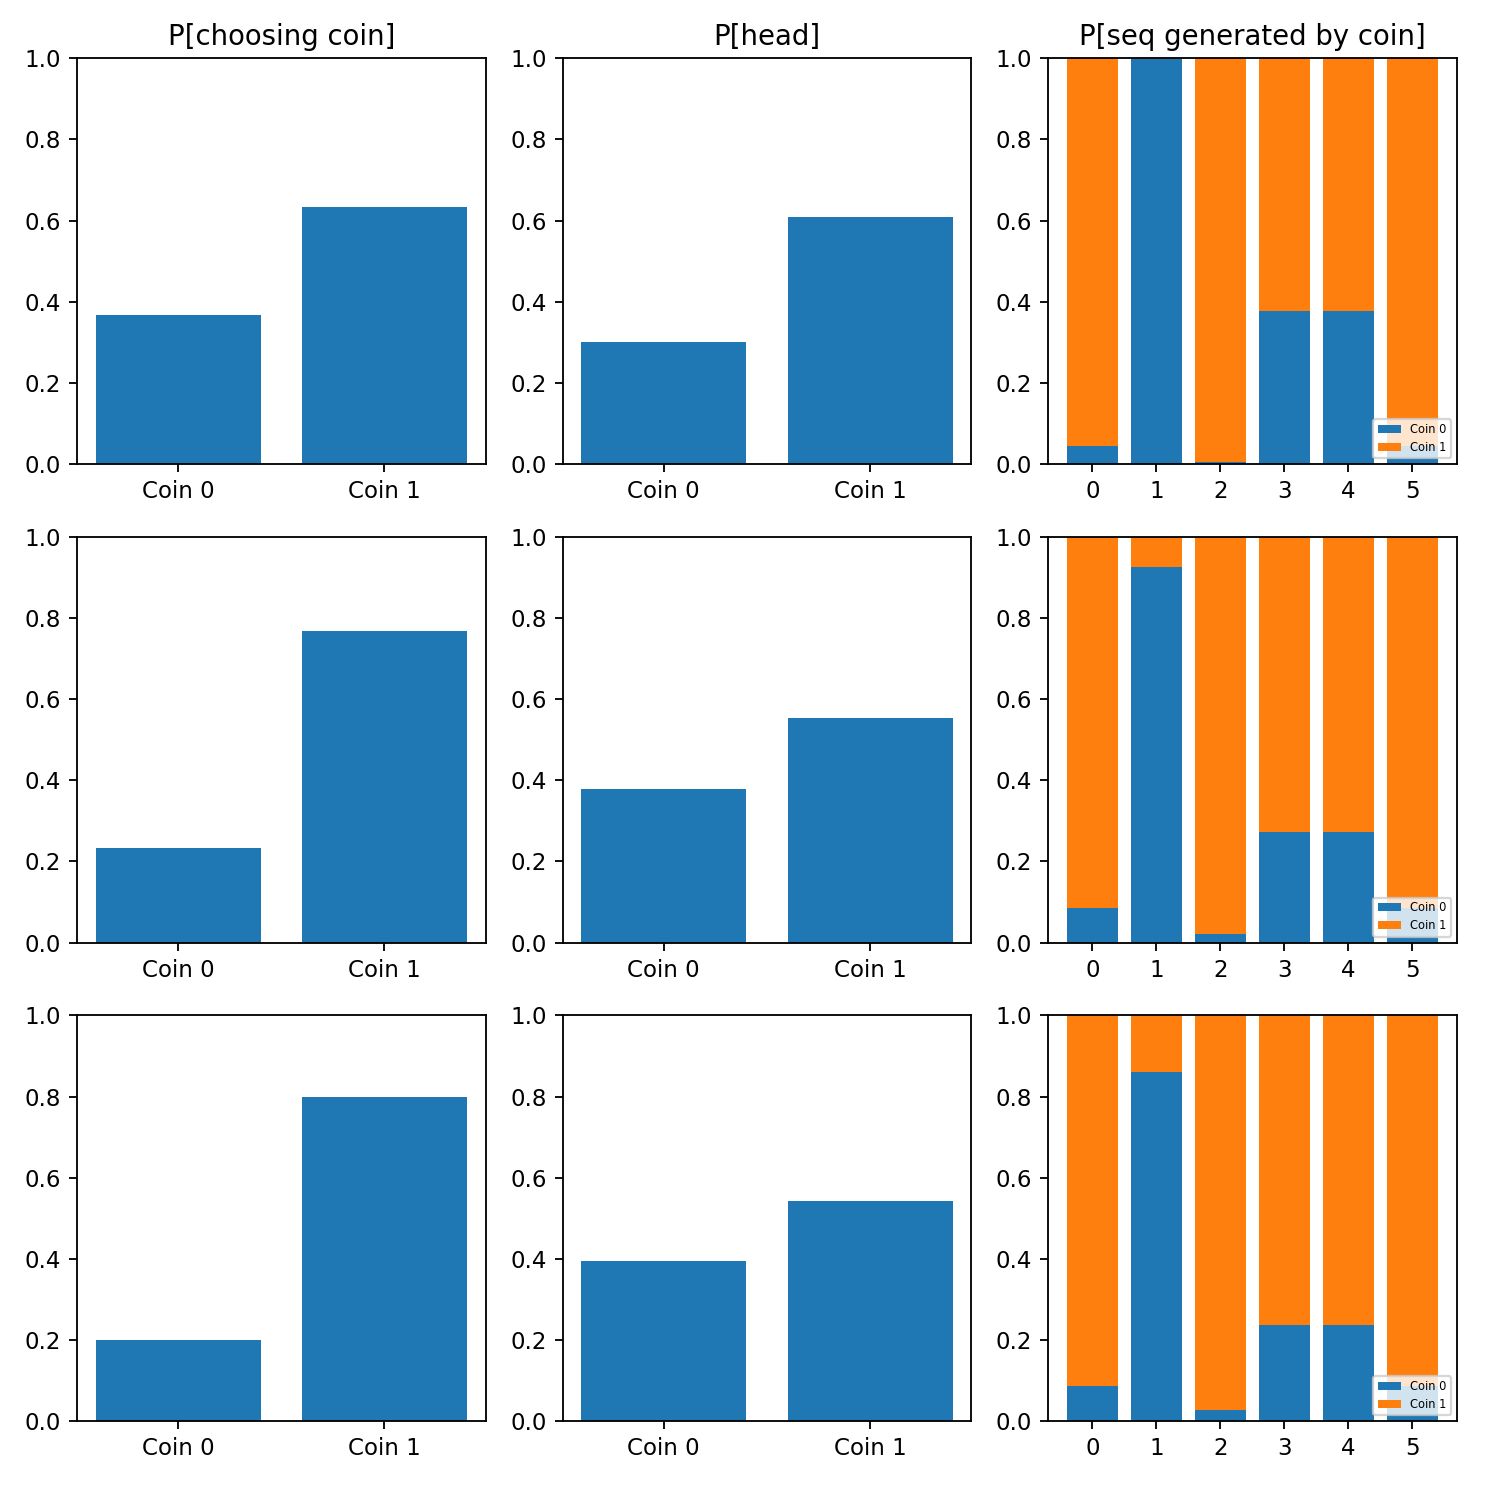

In [95]:
# visualizes the changes in coin params/probabilities between iterations
# NOTE: Doesn't work if process converged in one iteration

# how many sequences to show for the third plot
n_plot_seqs = 6
fig, ax = plt.subplots(iters,3, figsize = (9,3*iters))
labels1 = [f'Coin {i}' for i in range(n_coins)]
labels2 = [str(i) for i in range(n_plot_seqs)]
ax[0,0].set_title('P[choosing coin]')
ax[0,1].set_title('P[head]')
ax[0,2].set_title('P[seq generated by coin]')

for i in range(iters):
    gen_probs = []
    for j in range(n_coins):
        gen_probs.append(np.array([x[j] for x in exp_all[i][:n_plot_seqs]]))
    
    ax[i,0].set_ylim(0,1)
    ax[i,0].bar(labels1, alphas_all[i])
    
    ax[i,1].set_ylim(0,1)
    ax[i,1].bar(labels1, bias_all[i])
    
    ax[i,2].set_ylim(0,1)
    
    
    for j in range(n_coins):
        bottom = [0]*n_plot_seqs
        for k in range(j):
            bottom += gen_probs[k]
        ax[i,2].bar(labels2, gen_probs[j], bottom = bottom)
    ax[i,2].legend(labels1, loc=4, prop={'size': 5})
    
plt.tight_layout()

In [96]:
# runs the experiment multiple times, finding which set of parameters maximizes likelihood of data
# aims to overcome the issue of local minima
def run_multiple_experiments(n_iterations, n_coins, n_sequences, sequence_length, tol, sequences):
    best_likelihood = 0
    best_params = [0]*n_coins
    best_alphas = [0]*n_coins
    params = []
    likelihoods = []
    for seed in range(n_iterations):
        iters, pred_biases, alpha_hat, bias_all, exp_all, alphas_all = run_experiment(n_coins, n_sequences, sequence_length, tol, sequences)

        # calculate final data likelihood
        heads = np.array([len([x for x in sequence if x == 'H']) for sequence in sequences])
        tails = sequence_length-heads
        probs = np.array([alpha_hat[i]*(pred_bias**heads * (1-pred_bias)**tails) for i, pred_bias in enumerate(pred_biases)])
        probs = np.dstack([probs[a] for a in range(n_coins)])[0]
        expectations = np.array([np.array([b/sum(a) for b in a]) for a in probs])
        likelihood = np.mean(np.sum(probs*expectations,axis=1))
        if likelihood > best_likelihood:
            best_likelihood = likelihood
            best_params = pred_biases
            best_alphas = alpha_hat

        params.append(best_params)
        likelihoods.append(likelihood)
        
    return best_params, best_alphas, params, likelihoods, probs, expectations

best_params, best_alphas, params, likelihoods, probs, expectations = run_multiple_experiments(n_iterations, n_coins, n_sequences, sequence_length, tol, sequences)
print(f"Final biases estimate: {sorted(np.round(best_params,2))}")
print(f"True biases: {sorted(np.round(biases,2))}")
print()
print(f"Final alphas estimate: {sorted(np.round(best_alphas,2))}")
print(f"True alphas: {sorted(np.round(alpha,2))}")

Final biases estimate: [0.22, 0.53]
True biases: [0.43, 0.51]

Final alphas estimate: [0.05, 0.95]
True alphas: [0.42, 0.58]


In [97]:
# using a parameter sweep, generates a likelihood surface
# only works when n_coins = 2
if n_coins != 2:
    raise ValueError("This cell and those below only work when n_coins == 2")
x,y = np.meshgrid(np.arange(lower-0.1, upper+0.11, 0.01),np.arange(lower-0.1, upper+0.11, 0.01))
z = []
for i in range(len(x)):
    z_array = []
    for j in range(len(x[i])):
        pred_biases = [x[i][j],y[i][j]]
        heads = np.array([len([x for x in sequence if x == 'H']) for sequence in sequences])
        tails = sequence_length-heads
        probs = np.array([pred_bias**heads * (1-pred_bias)**tails for pred_bias in pred_biases]).reshape((n_sequences,n_coins))
        expectations = np.array([np.array([a/(a+b), b/(a+b)]) for a,b in probs])
        likelihood = np.mean(np.sum(probs*expectations,axis=1))
        z_array.append(likelihood)
    z.append(z_array)
        

In [98]:
# processing for the plot cell below
params, ind = np.unique(np.array(params),axis=0, return_index=True)
a = np.array([x[0] for x in params])
b = np.array([x[1] for x in params])
likelihoods = np.array(likelihoods)[ind]
m = np.array(z).max()*1.1
likelihoods = m - likelihoods
z = m - np.array(z)

In [100]:
%matplotlib notebook
#### Note that this line does not seem to work properly on colab

<IPython.core.display.Javascript object>


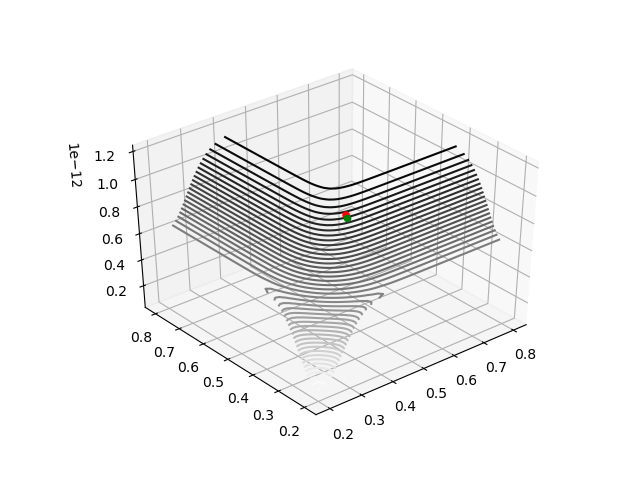

In [365]:
# plots a 3d "Loss surface"
# only works when n_coins = 2
# x axis = p[coin1 = head]
# y axis = p[coin2 = head]
# z axis = "loss value" of data at that x,y combo
# red dots represent different local minima that the algorithm converged to (unique)
# green dot represents the minima across 4 iterations
ax3 = plt.axes(projection='3d')
ax3.contour3D(x, y, np.array(z), 50, cmap='binary')
ax3.scatter3D(a[a != a[likelihoods.argmin()]], b[a != a[likelihoods.argmin()]], likelihoods[likelihoods != likelihoods.min()], color='Red')
ax3.scatter3D(a[likelihoods.argmin()],b[likelihoods.argmin()],likelihoods.min(), color='Green')